# IMAGE CLASSIFICATION NN PROJEKT - STAR WARS
### Radosław Praski

Project contains image classification script. Image classification is based on a Neural Network idea. Moreover, Neural Network as Convolutional Neural Network. 
Image classification dataset contains images from Star Wars movies. Classification referes to Jedi characters.

Project scheme:
1. Image dataset check
2. Image dataset preparation
3. Image dataset loading
4. Dataset separation to train, test and validiation data (action could be done earlier)
5. CNN application
6. Building variety of models
7. Building learning model
8. Analysis models
9. Cross Validiation (some)
10. Accuracy score
10. Conclusions

To operate on a script, user needs to download Star Wars Image dataset from repository. Basic dataset: https://www.kaggle.com/datasets/mathurinache/star-wars-images. Final dataset was prepared and splitted to train, val and test for script. Script consists setting path of image data source folder similar to script path.

#### Requred packages loading/importing

In [ ]:
!pip install opencv-python

In [1]:
from tensorflow.keras.layers import Conv2D, Input, Lambda, Dense, Flatten, Dropout, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Confision Matrix formula

In [2]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    #  This function prints and plots the confusion matrix.
    #  Normalization can be applied by setting `normalize=True`.
    
    import numpy as np
    import matplotlib.pyplot as plt
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Setting paths (same as notebook path)

In [2]:
img_folder_name = 'SW_Jedi_image_dataset'

In [3]:
dir_path = os.path.dirname(os.path.abspath("ML_NN_classification_Jedi_Git.ipynb"))
dir_path

'E:\\Radek\\Szkolenia\\Data_Science\\Repo_proj'

In [4]:
dataset_path = dir_path + '\\' + img_folder_name
dataset_path

'E:\\Radek\\Szkolenia\\Data_Science\\Repo_proj\\SW_Jedi_image_dataset'

#### Plotting random images from dataset

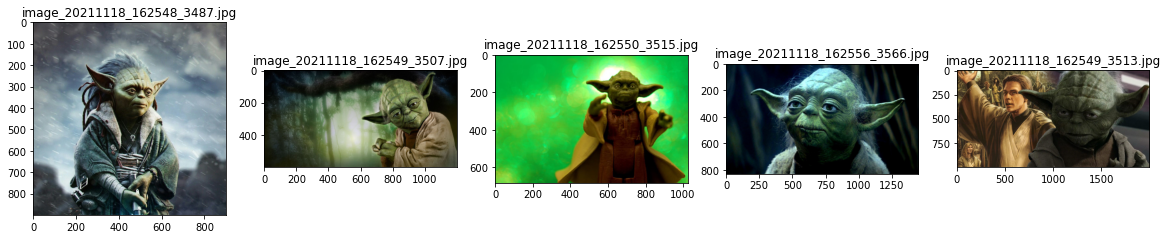

In [7]:
plt.figure(figsize=(20,20))
img_folder = dataset_path + '\\train\\Yoda'
for i in range(5):
    file_v = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file_v)
    img_v=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file_v)
    plt.imshow(img_v)

#### Image data paths tuple

In [5]:
train_path = dataset_path + '\\train'
val_path = dataset_path + '\\val'
test_path= dataset_path + '\\test'

data_paths = (train_path, val_path, test_path)
data_paths

('E:\\Radek\\Szkolenia\\Data_Science\\Repo_proj\\SW_Jedi_image_dataset\\train',
 'E:\\Radek\\Szkolenia\\Data_Science\\Repo_proj\\SW_Jedi_image_dataset\\val',
 'E:\\Radek\\Szkolenia\\Data_Science\\Repo_proj\\SW_Jedi_image_dataset\\test')

#### Image size checking for choosing correct, similar size

In [8]:
img_size = []

for folder in os.listdir(train_path):

    sub_path=train_path + "\\" + folder

    for img in os.listdir(sub_path):

        image_path=sub_path + "\\" + img

        img_arr=cv2.imread(image_path)
        
        img_size.append(img_arr.shape[0:2])
        
img_size_df = pd.DataFrame(img_size, columns = ['Width', 'Height'])

In [9]:
img_size_df.head()

,Width,Height
0,1236,981
1,900,900
2,900,900
3,900,900
4,900,900


In [10]:
img_size_df.describe()

,Width,Height
count,403.000000,403.000000
mean,1060.642680,1205.605459
std,583.969656,557.665626
min,150.000000,250.000000
25%,708.500000,800.000000
50%,900.000000,1072.000000
75%,1199.000000,1538.000000
max,4156.000000,5184.000000


In [6]:
target_size = (200, 200, 3) # chosen size of images

#### Standard and Augmented Data Generator

In [9]:
train_generator_std = ImageDataGenerator(rescale=1/255)

train_generator_aug = ImageDataGenerator(rescale=1./255,
                                         rotation_range=10,
                                         zoom_range=0.1,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         horizontal_flip=True,
                                         brightness_range = (0.9,1.1),
                                         fill_mode='nearest')

valid_generator = ImageDataGenerator(rescale=1/255)

test_generator = ImageDataGenerator(rescale=1/255)

In [10]:
print('Total number of images for "standard training":')
train_flow_std = train_generator_std.flow_from_directory(train_path,
                                                         target_size=target_size[0:2],
                                                         batch_size=32,
                                                         class_mode="categorical")

print('Total number of images for "augmented training":')
train_flow_aug = train_generator_aug.flow_from_directory(train_path,
                                                         target_size=target_size[0:2],
                                                         batch_size=32,
                                                         class_mode="categorical")

print('Total number of images for "validation":')
valid_flow = valid_generator.flow_from_directory(val_path,
                                                 target_size=target_size[0:2],
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=False)

print('Total number of images for "testing":')
test_flow = test_generator.flow_from_directory(test_path,
                                               target_size=target_size[0:2],
                                               batch_size=32,
                                               class_mode='categorical', 
                                               shuffle=False)

Total number of images for "standard training":
Found 403 images belonging to 7 classes.
Total number of images for "augmented training":
Found 403 images belonging to 7 classes.
Total number of images for "validation":
Found 105 images belonging to 7 classes.
Total number of images for "testing":
Found 140 images belonging to 7 classes.


#### Classes

In [11]:
n_classes = len(train_flow_std.class_indices)
n_classes

7

In [12]:
train_flow_std.class_indices

{'Anakin Skywalker': 0,
 'Kylo Ren': 1,
 'Luke Skywalker': 2,
 'Mace Windu': 3,
 'Obi-Wan': 4,
 'Qui-Gon Jinn': 5,
 'Yoda': 6}

In [13]:
category_names = [key for key in train_flow_std.class_indices]
category_names

['Anakin Skywalker',
 'Kylo Ren',
 'Luke Skywalker',
 'Mace Windu',
 'Obi-Wan',
 'Qui-Gon Jinn',
 'Yoda']

#### Visualize number of training images per category

Text(0.5, 1.0, 'Number of training images per category:')

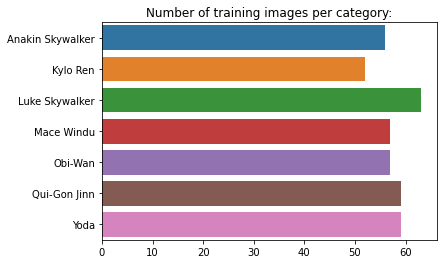

In [17]:
img_pr_cat = []
 
for category in category_names:
    sub_path = train_path + "\\" + category
    img_pr_cat.append(len(os.listdir(sub_path)))
 
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

### Building and checking own CNN model for Jedi Images

#### Standard Model within optimization

In [42]:
def std_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(8, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(16, 3, activation="relu"))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(32, 3, activation="relu"))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(110, "relu"))
    model.add(Dense(n_classes, "softmax"))
    
    return model

In [43]:
def deeper_std_model(input_shape):
    
    model = Sequential()
    model.add(Conv2D(16, 3, activation="relu", input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(32, 3, activation="relu"))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.1))
    model.add(Conv2D(64, 3, activation="relu"))
    model.add(MaxPool2D((2,2)))
    model.add(Flatten())
    model.add(Dense(110, "relu"))
    model.add(Dense(n_classes, "softmax"))
    
    return model

In [45]:
model_std_1 = std_model(target_size)
model_std_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0

In [46]:
model_std_2 = deeper_std_model(target_size)
model_std_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)       

Teaching model

In [47]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [48]:
model_std_1.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_1 = model_std_1.fit(train_flow_std,
                           validation_data=valid_flow,
                           callbacks=[early_stopping],
                           epochs=30)

Epoch 1/30
13/13 [==============================] - 20s 2s/step - loss: 2.3649 - accuracy: 0.1538 - val_loss: 1.9319 - val_accuracy: 0.1238
Epoch 2/30
13/13 [==============================] - 17s 1s/step - loss: 1.9093 - accuracy: 0.1811 - val_loss: 1.9048 - val_accuracy: 0.2000
Epoch 3/30
13/13 [==============================] - 18s 1s/step - loss: 1.8171 - accuracy: 0.3102 - val_loss: 1.8575 - val_accuracy: 0.2762
Epoch 4/30
13/13 [==============================] - 21s 2s/step - loss: 1.6495 - accuracy: 0.4318 - val_loss: 1.7859 - val_accuracy: 0.2952
Epoch 5/30
13/13 [==============================] - 23s 2s/step - loss: 1.4642 - accuracy: 0.4814 - val_loss: 1.6249 - val_accuracy: 0.4095
Epoch 6/30
13/13 [==============================] - 28s 2s/step - loss: 1.2649 - accuracy: 0.5757 - val_loss: 1.5746 - val_accuracy: 0.4190
Epoch 7/30
13/13 [==============================] - 21s 2s/step - loss: 1.0048 - accuracy: 0.6526 - val_loss: 1.5388 - val_accuracy: 0.4286
Epoch 8/30
13/13 [==

In [49]:
model_std_1.save('model_std_1.h5')

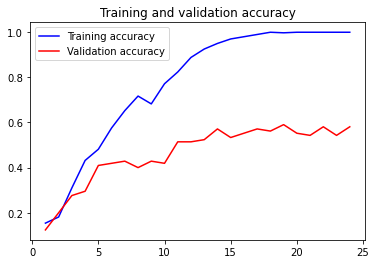

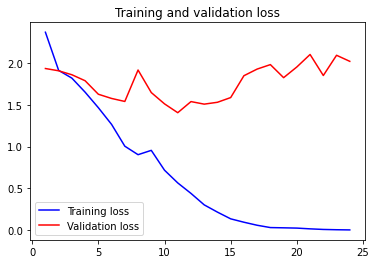

In [50]:
acc = answer_1.history['accuracy']
val_acc = answer_1.history['val_accuracy']
loss = answer_1.history['loss']
val_loss = answer_1.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
#plt.savefig('Loss.jpg')

In [51]:
y_test_std_1 = model_std_1.predict(test_flow)
y_test_std_1 = np.argmax(y_test_std_1, axis=1)

In [52]:
accuracy_std_1 = accuracy_score(test_flow.classes, y_test_std_1)
print("Accuracy in test set for standard model: %0.1f%% " % (accuracy_std_1 * 100))

Accuracy in test set for standard model: 55.0% 


In [53]:
model_std_2.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_2 = model_std_2.fit(train_flow_std,
                           validation_data=valid_flow,
                           callbacks=[early_stopping],
                           epochs=50)

Epoch 1/50
13/13 [==============================] - 22s 2s/step - loss: 2.0294 - accuracy: 0.1911 - val_loss: 1.9359 - val_accuracy: 0.2762
Epoch 2/50
13/13 [==============================] - 21s 2s/step - loss: 1.8428 - accuracy: 0.3251 - val_loss: 1.7536 - val_accuracy: 0.3333
Epoch 3/50
13/13 [==============================] - 21s 2s/step - loss: 1.4231 - accuracy: 0.5037 - val_loss: 1.6192 - val_accuracy: 0.3429
Epoch 4/50
13/13 [==============================] - 22s 2s/step - loss: 1.0676 - accuracy: 0.6104 - val_loss: 1.4321 - val_accuracy: 0.4381
Epoch 5/50
13/13 [==============================] - 20s 2s/step - loss: 0.8611 - accuracy: 0.7022 - val_loss: 1.3910 - val_accuracy: 0.5524
Epoch 6/50
13/13 [==============================] - 20s 2s/step - loss: 0.5498 - accuracy: 0.8164 - val_loss: 1.4816 - val_accuracy: 0.5524
Epoch 7/50
13/13 [==============================] - 22s 2s/step - loss: 0.3272 - accuracy: 0.9082 - val_loss: 1.3599 - val_accuracy: 0.5524
Epoch 8/50
13/13 [==

In [56]:
model_std_2.save('model_std_2.h5')

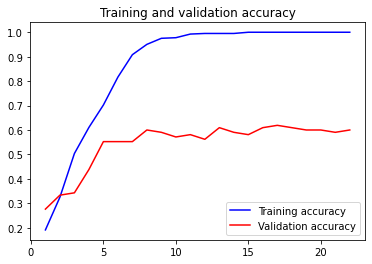

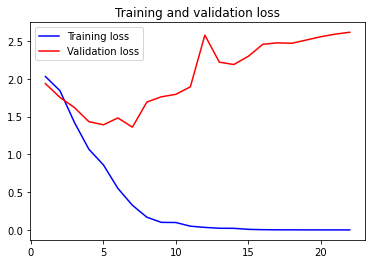

In [57]:
acc = answer_2.history['accuracy']
val_acc = answer_2.history['val_accuracy']
loss = answer_2.history['loss']
val_loss = answer_2.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [58]:
y_test_std_2 = model_std_2.predict(test_flow)
y_test_std_2 = np.argmax(y_test_std_2, axis=1)

In [59]:
accuracy_std_2 = accuracy_score(test_flow.classes, y_test_std_2)
print("Accuracy in test set for deper standard model: %0.1f%% " % (accuracy_std_2 * 100))

Accuracy in test set for deper standard model: 62.9% 


Definately, there is a need to improve accuracy. Let's check image augmentation.

Image Data Augmentation

In [60]:
model_aug_1 = std_model(target_size)
model_aug_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 198, 198, 8)       224       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 99, 99, 8)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 97, 97, 16)        1168      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 32)       

In [61]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [62]:
model_aug_1.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_3 = model_aug_1.fit(train_flow_aug,
                           validation_data=valid_flow,
                           callbacks=[early_stopping],
                           epochs=100)

Epoch 1/100
13/13 [==============================] - 25s 2s/step - loss: 1.9247 - accuracy: 0.1712 - val_loss: 1.8792 - val_accuracy: 0.1619
Epoch 2/100
13/13 [==============================] - 23s 2s/step - loss: 1.8471 - accuracy: 0.2109 - val_loss: 1.8579 - val_accuracy: 0.2762
Epoch 3/100
13/13 [==============================] - 23s 2s/step - loss: 1.7164 - accuracy: 0.2978 - val_loss: 2.0197 - val_accuracy: 0.3238
Epoch 4/100
13/13 [==============================] - 24s 2s/step - loss: 1.6392 - accuracy: 0.3400 - val_loss: 1.9049 - val_accuracy: 0.3143
Epoch 5/100
13/13 [==============================] - 24s 2s/step - loss: 1.5164 - accuracy: 0.4690 - val_loss: 1.8245 - val_accuracy: 0.3714
Epoch 6/100
13/13 [==============================] - 21s 2s/step - loss: 1.4298 - accuracy: 0.4417 - val_loss: 1.6692 - val_accuracy: 0.4095
Epoch 7/100
13/13 [==============================] - 22s 2s/step - loss: 1.2924 - accuracy: 0.4938 - val_loss: 1.6984 - val_accuracy: 0.4190
Epoch 8/100
1

In [63]:
model_aug_1.save('model_aug_1.h5')

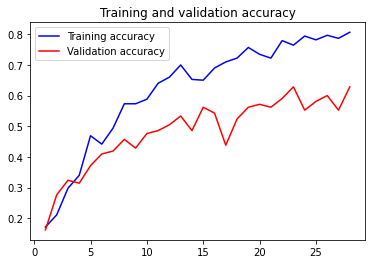

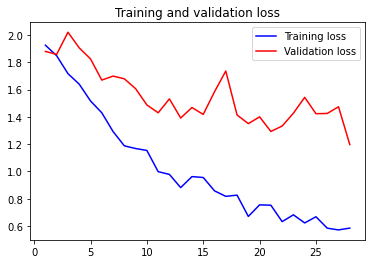

In [64]:
acc = answer_3.history['accuracy']
val_acc = answer_3.history['val_accuracy']
loss = answer_3.history['loss']
val_loss = answer_3.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [65]:
y_test_aug_1 = model_aug_1.predict(test_flow)
y_test_aug_1 = np.argmax(y_test_aug_1, axis=1)

In [66]:
accuracy_aug_1 = accuracy_score(test_flow.classes, y_test_aug_1)
print("Accuracy in test set for augmented model: %0.1f%% " % (accuracy_aug_1 * 100))

Accuracy in test set for augmented model: 55.0% 


In [67]:
model_aug_2 = deeper_std_model(target_size)
model_aug_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 64)       

In [68]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [69]:
model_aug_2.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_4 = model_aug_2.fit(train_flow_aug,
                           validation_data=valid_flow,
                           callbacks=[early_stopping],
                           epochs=100)

Epoch 1/100
13/13 [==============================] - 25s 2s/step - loss: 2.0569 - accuracy: 0.1390 - val_loss: 1.8890 - val_accuracy: 0.1810
Epoch 2/100
13/13 [==============================] - 27s 2s/step - loss: 1.8516 - accuracy: 0.2457 - val_loss: 1.8506 - val_accuracy: 0.2381
Epoch 3/100
13/13 [==============================] - 24s 2s/step - loss: 1.7441 - accuracy: 0.3151 - val_loss: 1.7569 - val_accuracy: 0.3238
Epoch 4/100
13/13 [==============================] - 25s 2s/step - loss: 1.6163 - accuracy: 0.3846 - val_loss: 1.6636 - val_accuracy: 0.3429
Epoch 5/100
13/13 [==============================] - 25s 2s/step - loss: 1.4514 - accuracy: 0.4615 - val_loss: 1.6913 - val_accuracy: 0.3905
Epoch 6/100
13/13 [==============================] - 24s 2s/step - loss: 1.4806 - accuracy: 0.4591 - val_loss: 1.6000 - val_accuracy: 0.3619
Epoch 7/100
13/13 [==============================] - 25s 2s/step - loss: 1.2931 - accuracy: 0.5533 - val_loss: 1.5666 - val_accuracy: 0.4571
Epoch 8/100
1

In [70]:
model_aug_2.save('model_aug_2.h5')

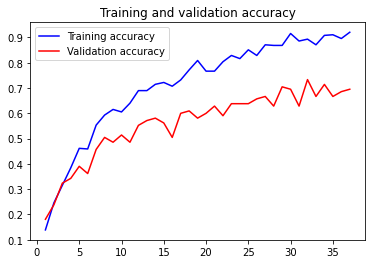

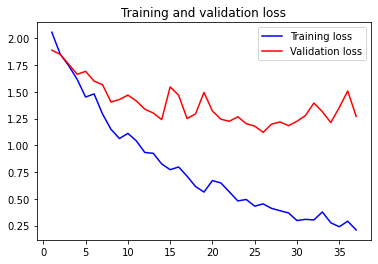

In [71]:
acc = answer_4.history['accuracy']
val_acc = answer_4.history['val_accuracy']
loss = answer_4.history['loss']
val_loss = answer_4.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [72]:
y_test_aug_2 = model_aug_2.predict(test_flow)
y_test_aug_2 = np.argmax(y_test_aug_2, axis=1)

In [73]:
accuracy_aug_2 = accuracy_score(test_flow.classes, y_test_aug_2)
print("Accuracy in test set for deeper augmented model: %0.1f%% " % (accuracy_aug_2 * 100))

Accuracy in test set for deeper augmented model: 63.6% 


Adding Learning Rate Scheduler

In [34]:
# seting decreasing Learning Rate
def scheduler_1(epoch, lr):
    lr = 1e-3
    if epoch == 0:
        return lr
    else:
        return lr / epoch

In [35]:
lr_schedule_1 = LearningRateScheduler(scheduler_1)

In [36]:
model_aug_3 = deeper_std_model(target_size)
model_aug_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 64)       

In [37]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [38]:
model_aug_3.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_5 = model_aug_3.fit(train_flow_aug,
                           validation_data=valid_flow,
                           callbacks=[early_stopping, lr_schedule_1],
                           epochs=40)

Epoch 1/40
13/13 [==============================] - 25s 2s/step - loss: 2.1364 - accuracy: 0.1340 - val_loss: 1.9097 - val_accuracy: 0.1619
Epoch 2/40
13/13 [==============================] - 24s 2s/step - loss: 1.8726 - accuracy: 0.2333 - val_loss: 1.8142 - val_accuracy: 0.2095
Epoch 3/40
13/13 [==============================] - 24s 2s/step - loss: 1.8007 - accuracy: 0.2878 - val_loss: 1.7673 - val_accuracy: 0.3048
Epoch 4/40
13/13 [==============================] - 26s 2s/step - loss: 1.7127 - accuracy: 0.3375 - val_loss: 1.7491 - val_accuracy: 0.3048
Epoch 5/40
13/13 [==============================] - 24s 2s/step - loss: 1.6360 - accuracy: 0.3821 - val_loss: 1.7561 - val_accuracy: 0.2857
Epoch 6/40
13/13 [==============================] - 24s 2s/step - loss: 1.6085 - accuracy: 0.3797 - val_loss: 1.6880 - val_accuracy: 0.3048
Epoch 7/40
13/13 [==============================] - 24s 2s/step - loss: 1.5486 - accuracy: 0.4491 - val_loss: 1.6906 - val_accuracy: 0.3048
Epoch 8/40
13/13 [==

In [ ]:
model_aug_3.save('model_aug_3.h5')

#### Decreasing Learning Rate is incorrect option so it won't be considered in conclusions

In [88]:
# seting increasing Learning Rate
decay = 0.1
def scheduler_2(epoch, lr):
    lr = 1e-3
    if epoch == 0:
        return lr
    else:
        return (lr * (1 + decay * epoch))

In [89]:
lr_schedule_2 = LearningRateScheduler(scheduler_2)

In [90]:
model_aug_4 = deeper_std_model(target_size)
model_aug_4.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 23, 23, 64)       

In [91]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [92]:
model_aug_4.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_6 = model_aug_4.fit(train_flow_aug,
                           validation_data=valid_flow,
                           callbacks=[early_stopping, lr_schedule_2],
                           epochs=40)

Epoch 1/40
13/13 [==============================] - 25s 2s/step - loss: 2.1339 - accuracy: 0.2084 - val_loss: 1.9164 - val_accuracy: 0.2095
Epoch 2/40
13/13 [==============================] - 26s 2s/step - loss: 1.8814 - accuracy: 0.2481 - val_loss: 1.8882 - val_accuracy: 0.2000
Epoch 3/40
13/13 [==============================] - 26s 2s/step - loss: 1.8205 - accuracy: 0.2878 - val_loss: 1.7755 - val_accuracy: 0.3238
Epoch 4/40
13/13 [==============================] - 24s 2s/step - loss: 1.6338 - accuracy: 0.3772 - val_loss: 1.8024 - val_accuracy: 0.3238
Epoch 5/40
13/13 [==============================] - 25s 2s/step - loss: 1.6172 - accuracy: 0.4069 - val_loss: 1.5699 - val_accuracy: 0.4286
Epoch 6/40
13/13 [==============================] - 24s 2s/step - loss: 1.4575 - accuracy: 0.4789 - val_loss: 1.5276 - val_accuracy: 0.4476
Epoch 7/40
13/13 [==============================] - 25s 2s/step - loss: 1.3804 - accuracy: 0.5012 - val_loss: 1.4955 - val_accuracy: 0.4095
Epoch 8/40
13/13 [==

In [93]:
model_aug_4.save('model_aug_4.h5')

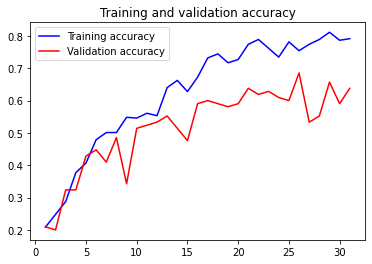

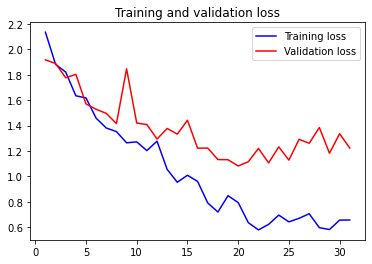

In [94]:
acc = answer_6.history['accuracy']
val_acc = answer_6.history['val_accuracy']
loss = answer_6.history['loss']
val_loss = answer_6.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [95]:
y_test_aug_4 = model_aug_4.predict(test_flow)
y_test_aug_4 = np.argmax(y_test_aug_4, axis=1)

In [96]:
accuracy_aug_4 = accuracy_score(test_flow.classes, y_test_aug_4)
print("Accuracy in test set for deeper augmented model with Learning Rate Schedule: %0.1f%% " % (accuracy_aug_4 * 100))

Accuracy in test set for deeper augmented model with Learning Rate Schedule: 60.0% 


#### Transfer learning

#### VGG19

In [98]:
model_vgg19 = VGG19(weights="imagenet", include_top=False, input_shape=target_size)

In [99]:
model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [100]:
top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dense(110, "relu"))
top_model.add(Dense(n_classes, "softmax"))

In [101]:
transfer_model = Sequential()
transfer_model.add(model_vgg19)
transfer_model.add(top_model)

transfer_model.layers[0].trainable = False

In [102]:
transfer_model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
sequential_18 (Sequential)   (None, 7)                 2028407   
Total params: 22,052,791
Trainable params: 2,028,407
Non-trainable params: 20,024,384
_________________________________________________________________


In [103]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [104]:
transfer_model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_7 = transfer_model.fit(train_flow_aug,
                              validation_data=valid_flow,
                              callbacks=[early_stopping],
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 157s 12s/step - loss: 2.4084 - accuracy: 0.2804 - val_loss: 1.7733 - val_accuracy: 0.4000
Epoch 2/100
13/13 [==============================] - 154s 12s/step - loss: 1.4100 - accuracy: 0.5136 - val_loss: 1.3806 - val_accuracy: 0.4286
Epoch 3/100
13/13 [==============================] - 154s 12s/step - loss: 0.9940 - accuracy: 0.6625 - val_loss: 1.1756 - val_accuracy: 0.5619
Epoch 4/100
13/13 [==============================] - 154s 12s/step - loss: 0.8487 - accuracy: 0.7395 - val_loss: 1.0143 - val_accuracy: 0.6286
Epoch 5/100
13/13 [==============================] - 154s 12s/step - loss: 0.6142 - accuracy: 0.8288 - val_loss: 0.9951 - val_accuracy: 0.6667
Epoch 6/100
13/13 [==============================] - 154s 12s/step - loss: 0.6132 - accuracy: 0.8288 - val_loss: 1.0626 - val_accuracy: 0.6095
Epoch 7/100
13/13 [==============================] - 154s 12s/step - loss: 0.4688 - accuracy: 0.8883 - val_loss: 0.9698 - val_accuracy: 0.6857

In [105]:
transfer_model.save('transfer_model.h5')

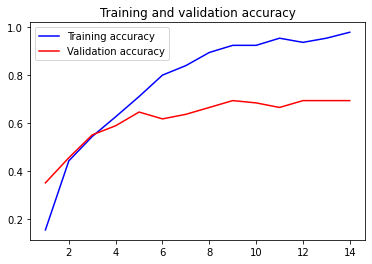

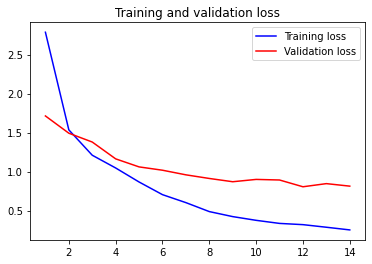

In [31]:
acc = answer_7.history['accuracy']
val_acc = answer_7.history['val_accuracy']
loss = answer_7.history['loss']
val_loss = answer_7.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [32]:
transfer_model.evaluate(test_flow)

5/5 [==============================] - 31s 6s/step - loss: 0.8566 - accuracy: 0.7286


[0.8566324710845947, 0.7285714149475098]

In [33]:
y_pred_TL_1 = transfer_model.predict(test_flow)
y_pred_TL_1 = np.argmax(y_pred_TL_1, axis=1)

In [52]:
accuracy_TL_1 = accuracy_score(test_flow.classes, y_pred_TL_1)
print("Accuracy in test set for transfer learning VGG19 augmented model 1: %0.1f%% " % (accuracy_TL_1 * 100))

Accuracy in test set for transfer learning VGG19 augmented model 1: 72.9% 


Confusion matrix, without normalization


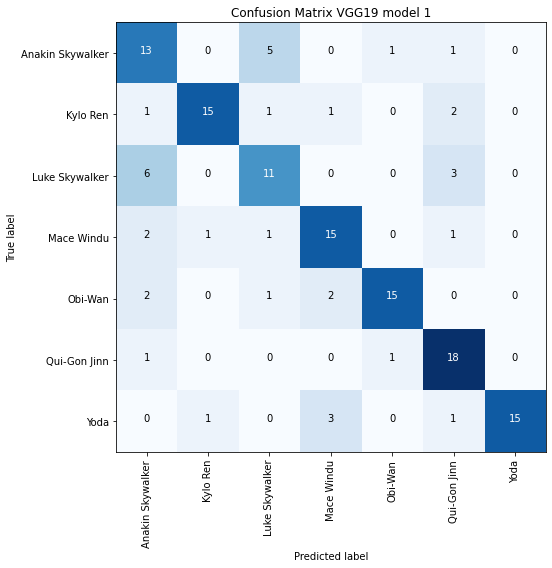

In [53]:
cm_TL_1 = confusion_matrix(test_flow.classes, y_pred_TL_1)
plot_confusion_matrix(cm_TL_1, classes = category_names,
                      title='Confusion Matrix VGG19 model 1', normalize=False)#, figname = 'Confusion_matrix_TL_std_VGG19.jpg')

We will try to check validiation accuracy for VGG19 model additional trainable layers from VGG19

In [115]:
def TL_trainable_layers(TM, number_of_layers, input_size):
    # TM - transfer learning Keras application (ie. Xception, VGG19, ResNet50)
    # number_of_layers - number of trainable layers from TM counted from last
    b_model = TM(weights="imagenet", include_top=False, input_shape=input_size)
    
    if number_of_layers > len(b_model.layers):
        number_of_layers = len(b_model.layers)
        
    t_model = Sequential()
    
    for layer in b_model.layers[0:(len(b_model.layers) - number_of_layers)]:
        t_model.add(layer)
        layer.trainable = False
    for layer in b_model.layers[(len(b_model.layers) - number_of_layers):len(b_model.layers)]:
        t_model.add(layer)
        layer.trainable = True
    
    t_model.add(Flatten())
    t_model.add(Dense(110, "relu"))
    t_model.add(Dense(n_classes, "softmax"))
    
    return t_model

In [116]:
transfer_model_2 = TL_trainable_layers(VGG19, 2, target_size)

In [117]:
transfer_model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 50, 50, 256)      

In [118]:
# Check the trainable status of the individual layers
for layer in transfer_model_2.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB0235B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB0239A0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000144D63EF910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB035790> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB02F1F0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000144D667B310> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB038880> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB03F700> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB03F4F0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000144DB045D30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000144DB02E550> False
<tensorflow.python.ke

In [119]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [120]:
transfer_model_2.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_8 = transfer_model_2.fit(train_flow_aug,
                                validation_data=valid_flow,
                                callbacks=[early_stopping],
                                epochs=100)

Epoch 1/100
13/13 [==============================] - 206s 16s/step - loss: 2.5640 - accuracy: 0.2333 - val_loss: 1.8103 - val_accuracy: 0.2190
Epoch 2/100
13/13 [==============================] - 171s 13s/step - loss: 1.4108 - accuracy: 0.4888 - val_loss: 1.3513 - val_accuracy: 0.5143
Epoch 3/100
13/13 [==============================] - 166s 13s/step - loss: 1.0459 - accuracy: 0.5980 - val_loss: 1.2854 - val_accuracy: 0.5333
Epoch 4/100
13/13 [==============================] - 177s 14s/step - loss: 0.6824 - accuracy: 0.7643 - val_loss: 0.8499 - val_accuracy: 0.7333
Epoch 5/100
13/13 [==============================] - 172s 13s/step - loss: 0.5482 - accuracy: 0.8139 - val_loss: 0.8311 - val_accuracy: 0.7048
Epoch 6/100
13/13 [==============================] - 171s 13s/step - loss: 0.4019 - accuracy: 0.8759 - val_loss: 0.8613 - val_accuracy: 0.7524
Epoch 7/100
13/13 [==============================] - 163s 13s/step - loss: 0.2586 - accuracy: 0.9256 - val_loss: 0.7637 - val_accuracy: 0.7714

In [121]:
transfer_model_2.save('transfer_model_2.h5')

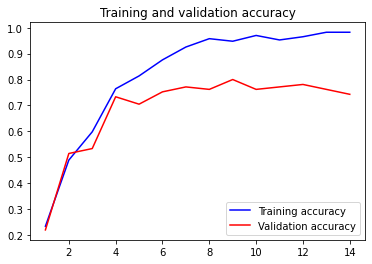

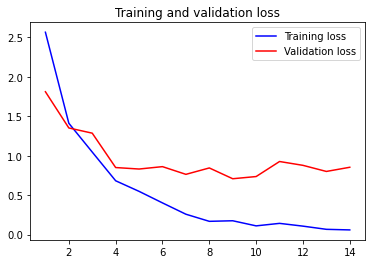

In [123]:
acc = answer_8.history['accuracy']
val_acc = answer_8.history['val_accuracy']
loss = answer_8.history['loss']
val_loss = answer_8.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [124]:
transfer_model_2.evaluate(test_flow)

5/5 [==============================] - 31s 6s/step - loss: 1.0410 - accuracy: 0.7429


[1.0409972667694092, 0.7428571581840515]

In [125]:
y_pred_TL_2 = transfer_model_2.predict(test_flow)
y_pred_TL_2 = np.argmax(y_pred_TL_2, axis=1)

In [126]:
accuracy_TL_2 = accuracy_score(test_flow.classes, y_pred_TL_2)
print("Accuracy in test set for transfer learning VGG19 augmented model 2: %0.1f%% " % (accuracy_TL_2 * 100))

Accuracy in test set for transfer learning VGG19 augmented model 2: 74.3% 


#### Xception

In [118]:
model_Xception = Xception(weights="imagenet", include_top=False, input_shape=target_size)

In [119]:
model_Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 99, 99, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 99, 99, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 99, 99, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [120]:
top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dense(110, "relu"))
top_model.add(Dense(n_classes, "softmax"))

In [121]:
transfer_model_3 = Sequential()
transfer_model_3.add(model_Xception)
transfer_model_3.add(top_model)

transfer_model_3.layers[0].trainable = False

In [122]:
transfer_model_3.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
sequential_20 (Sequential)   (None, 7)                 11039607  
Total params: 31,901,087
Trainable params: 11,039,607
Non-trainable params: 20,861,480
_________________________________________________________________


In [123]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [124]:
transfer_model_3.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_9 = transfer_model_3.fit(train_flow_aug,
                                validation_data=valid_flow,
                                callbacks=[early_stopping],
                                epochs=100)

Epoch 1/100
13/13 [==============================] - 65s 5s/step - loss: 8.3674 - accuracy: 0.2730 - val_loss: 1.5840 - val_accuracy: 0.3905
Epoch 2/100
13/13 [==============================] - 66s 5s/step - loss: 1.4074 - accuracy: 0.4069 - val_loss: 1.4823 - val_accuracy: 0.4286
Epoch 3/100
13/13 [==============================] - 66s 5s/step - loss: 1.0785 - accuracy: 0.5608 - val_loss: 1.4173 - val_accuracy: 0.5143
Epoch 4/100
13/13 [==============================] - 66s 5s/step - loss: 0.9943 - accuracy: 0.6551 - val_loss: 1.3438 - val_accuracy: 0.6000
Epoch 5/100
13/13 [==============================] - 66s 5s/step - loss: 0.7309 - accuracy: 0.7444 - val_loss: 1.1260 - val_accuracy: 0.6857
Epoch 6/100
13/13 [==============================] - 67s 5s/step - loss: 0.6226 - accuracy: 0.7792 - val_loss: 1.1870 - val_accuracy: 0.7238
Epoch 7/100
13/13 [==============================] - 65s 5s/step - loss: 0.4006 - accuracy: 0.8536 - val_loss: 1.4575 - val_accuracy: 0.7333
Epoch 8/100
1

In [125]:
transfer_model_3.save('transfer_model_3.h5')

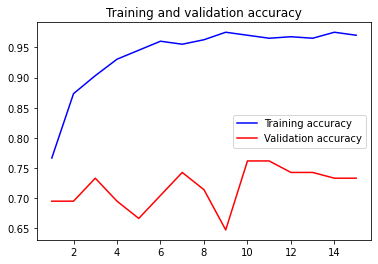

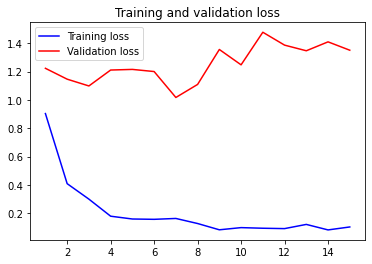

In [77]:
acc = answer_9.history['accuracy']
val_acc = answer_9.history['val_accuracy']
loss = answer_9.history['loss']
val_loss = answer_9.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [24]:
transfer_model_3.evaluate(test_flow)

5/5 [==============================] - 13s 3s/step - loss: 0.9165 - accuracy: 0.7429


[0.9164990186691284, 0.7428571581840515]

In [22]:
y_pred_TL_3 = transfer_model_3.predict(test_flow)
y_pred_TL_3 = np.argmax(y_pred_TL_3, axis=1)

In [23]:
accuracy_TL_3 = accuracy_score(test_flow.classes, y_pred_TL_3)
print("Accuracy in test set for transfer learning Xception augmented model: %0.1f%% " % (accuracy_TL_3 * 100))

Accuracy in test set for transfer learning Xception augmented model: 74.3% 


### "TL_trainable_layers" had arasied shape error for Xception module so learning was ended with untrainable layers

#### VGG16

In [43]:
model_vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=target_size)

In [44]:
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [45]:
top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dense(110, "relu"))
top_model.add(Dense(n_classes, "softmax"))

In [46]:
transfer_model_5 = Sequential()
transfer_model_5.add(model_vgg16)
transfer_model_5.add(top_model)

transfer_model_5.layers[0].trainable = False

In [47]:
transfer_model_5.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
sequential_12 (Sequential)   (None, 7)                 2028407   
Total params: 16,743,095
Trainable params: 2,028,407
Non-trainable params: 14,714,688
_________________________________________________________________


In [48]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [49]:
transfer_model_5.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_11 = transfer_model_5.fit(train_flow_aug,
                                 validation_data=valid_flow,
                                 callbacks=[early_stopping],
                                 epochs=100)

Epoch 1/100
13/13 [==============================] - 159s 12s/step - loss: 2.8644 - accuracy: 0.2208 - val_loss: 1.6935 - val_accuracy: 0.3810
Epoch 2/100
13/13 [==============================] - 142s 11s/step - loss: 1.3822 - accuracy: 0.5012 - val_loss: 1.5022 - val_accuracy: 0.5048
Epoch 3/100
13/13 [==============================] - 143s 11s/step - loss: 1.0591 - accuracy: 0.6328 - val_loss: 1.1517 - val_accuracy: 0.5714
Epoch 4/100
13/13 [==============================] - 147s 11s/step - loss: 0.8836 - accuracy: 0.7221 - val_loss: 1.0948 - val_accuracy: 0.5619
Epoch 5/100
13/13 [==============================] - 138s 11s/step - loss: 0.7059 - accuracy: 0.7841 - val_loss: 0.9982 - val_accuracy: 0.6857
Epoch 6/100
13/13 [==============================] - 138s 11s/step - loss: 0.5473 - accuracy: 0.8536 - val_loss: 0.9924 - val_accuracy: 0.5905
Epoch 7/100
13/13 [==============================] - 132s 10s/step - loss: 0.4981 - accuracy: 0.8710 - val_loss: 0.9199 - val_accuracy: 0.6952

In [90]:
transfer_model_5.save('transfer_model_5.h5')

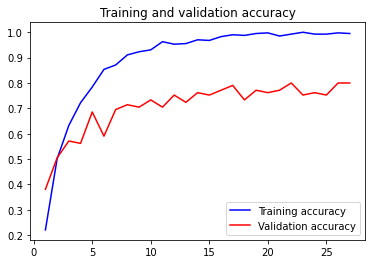

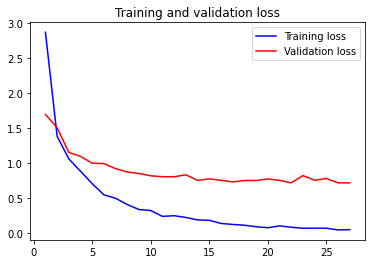

In [50]:
acc = answer_11.history['accuracy']
val_acc = answer_11.history['val_accuracy']
loss = answer_11.history['loss']
val_loss = answer_11.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [51]:
transfer_model_5.evaluate(test_flow)

5/5 [==============================] - 27s 5s/step - loss: 0.7016 - accuracy: 0.7786


[0.7015584111213684, 0.7785714268684387]

In [26]:
y_pred_TL_5 = transfer_model_5.predict(test_flow)
y_pred_TL_5 = np.argmax(y_pred_TL_5, axis=1)

In [27]:
accuracy_TL_5 = accuracy_score(test_flow.classes, y_pred_TL_5)
print("Accuracy in test set for transfer learning VGG16 augmented model: %0.1f%% " % (accuracy_TL_5 * 100))

Accuracy in test set for transfer learning VGG16 augmented model: 77.9% 


Additional layers for VGG16 model

In [75]:
transfer_model_6 = TL_trainable_layers(VGG16, 2, target_size)

In [76]:
transfer_model_6.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 50, 50, 256)     

In [77]:
# Check the trainable status of the individual layers
for layer in transfer_model_6.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867A0A60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256B0664B20> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000256867A09D0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867D88B0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867DE760> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000256867DE550> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867E3D60> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867E7340> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867EE940> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x00000256867F4610> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x00000256867FEA30> False
<tensorflow.python.ke

In [78]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [91]:
transfer_model_6.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_12 = transfer_model_6.fit(train_flow_aug,
                                validation_data=valid_flow,
                                callbacks=[early_stopping],
                                epochs=100)

Epoch 1/100
13/13 [==============================] - 148s 11s/step - loss: 1.3110 - accuracy: 0.5310 - val_loss: 1.3557 - val_accuracy: 0.5333
Epoch 2/100
13/13 [==============================] - 130s 10s/step - loss: 0.8253 - accuracy: 0.7122 - val_loss: 1.0093 - val_accuracy: 0.6571
Epoch 3/100
13/13 [==============================] - 134s 10s/step - loss: 0.5200 - accuracy: 0.8313 - val_loss: 0.9058 - val_accuracy: 0.7143
Epoch 4/100
13/13 [==============================] - 129s 10s/step - loss: 0.3645 - accuracy: 0.8883 - val_loss: 0.9062 - val_accuracy: 0.7524
Epoch 5/100
13/13 [==============================] - 131s 10s/step - loss: 0.2525 - accuracy: 0.9181 - val_loss: 0.8200 - val_accuracy: 0.8286
Epoch 6/100
13/13 [==============================] - 130s 10s/step - loss: 0.2084 - accuracy: 0.9380 - val_loss: 1.2888 - val_accuracy: 0.7143
Epoch 7/100
13/13 [==============================] - 130s 10s/step - loss: 0.1581 - accuracy: 0.9454 - val_loss: 0.8960 - val_accuracy: 0.8000

In [92]:
transfer_model_6.save('transfer_model_6.h5')

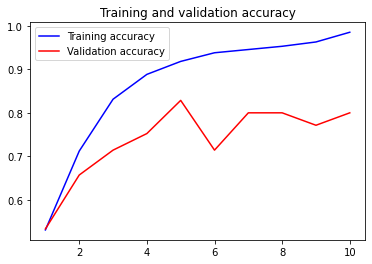

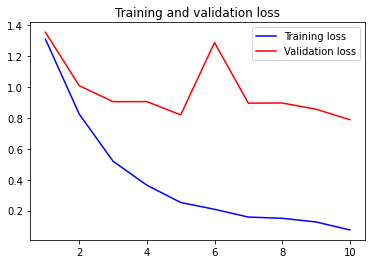

In [93]:
acc = answer_12.history['accuracy']
val_acc = answer_12.history['val_accuracy']
loss = answer_12.history['loss']
val_loss = answer_12.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [94]:
transfer_model_6.evaluate(test_flow)

5/5 [==============================] - 25s 5s/step - loss: 0.8976 - accuracy: 0.7429


[0.8976457715034485, 0.7428571581840515]

In [29]:
y_pred_TL_6 = transfer_model_6.predict(test_flow)
y_pred_TL_6 = np.argmax(y_pred_TL_6, axis=1)

In [30]:
accuracy_TL_6 = accuracy_score(test_flow.classes, y_pred_TL_6)
print("Accuracy in test set for transfer learning VGG16 augmented model 2: %0.1f%% " % (accuracy_TL_6 * 100))

Accuracy in test set for transfer learning VGG16 augmented model 2: 74.3% 


#### InceptionResNetV2

In [57]:
model_inception = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=target_size)

219062272/219055592 [==============================] - 48s 0us/step


In [58]:
model_inception.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 99, 99, 32)   864         input_14[0][0]                   
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 99, 99, 32)   96          conv2d_32[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization_32[0][0]     
________________________________________________________________________________

batch_normalization_131 (BatchN (None, 10, 10, 192)  576         conv2d_131[0][0]                 
__________________________________________________________________________________________________
activation_96 (Activation)      (None, 10, 10, 192)  0           batch_normalization_128[0][0]    
__________________________________________________________________________________________________
activation_99 (Activation)      (None, 10, 10, 192)  0           batch_normalization_131[0][0]    
__________________________________________________________________________________________________
block17_6_mixed (Concatenate)   (None, 10, 10, 384)  0           activation_96[0][0]              
                                                                 activation_99[0][0]              
__________________________________________________________________________________________________
block17_6_conv (Conv2D)         (None, 10, 10, 1088) 418880      block17_6_mixed[0][0]            
__________

__________________________________________________________________________________________________
conv_7b_bn (BatchNormalization) (None, 4, 4, 1536)   4608        conv_7b[0][0]                    
__________________________________________________________________________________________________
conv_7b_ac (Activation)         (None, 4, 4, 1536)   0           conv_7b_bn[0][0]                 
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
__________________________________________________________________________________________________


In [59]:
top_model = Sequential()
top_model.add(Flatten())
top_model.add(Dense(110, "relu"))
top_model.add(Dense(n_classes, "softmax"))

In [60]:
transfer_model_7 = Sequential()
transfer_model_7.add(model_inception)
transfer_model_7.add(top_model)

transfer_model_7.layers[0].trainable = False

In [61]:
transfer_model_7.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
sequential_14 (Sequential)   (None, 7)                 2704247   
Total params: 57,040,983
Trainable params: 2,704,247
Non-trainable params: 54,336,736
_________________________________________________________________


In [62]:
early_stopping = EarlyStopping(monitor="val_accuracy", 
                               patience=5,
                               restore_best_weights=True)

In [63]:
transfer_model_7.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

answer_13 = transfer_model_7.fit(train_flow_aug,
                                 validation_data=valid_flow,
                                 callbacks=[early_stopping],
                                 epochs=100)

Epoch 1/100
13/13 [==============================] - 74s 6s/step - loss: 13.3040 - accuracy: 0.3027 - val_loss: 4.7209 - val_accuracy: 0.2762
Epoch 2/100
13/13 [==============================] - 82s 6s/step - loss: 2.0262 - accuracy: 0.4342 - val_loss: 1.3190 - val_accuracy: 0.4381
Epoch 3/100
13/13 [==============================] - 76s 6s/step - loss: 1.3921 - accuracy: 0.4888 - val_loss: 1.3950 - val_accuracy: 0.4952
Epoch 4/100
13/13 [==============================] - 85s 7s/step - loss: 1.2938 - accuracy: 0.5434 - val_loss: 1.2207 - val_accuracy: 0.5524
Epoch 5/100
13/13 [==============================] - 78s 6s/step - loss: 1.0296 - accuracy: 0.6352 - val_loss: 1.1900 - val_accuracy: 0.5333
Epoch 6/100
13/13 [==============================] - 92s 7s/step - loss: 0.8846 - accuracy: 0.6600 - val_loss: 1.1643 - val_accuracy: 0.5905
Epoch 7/100
13/13 [==============================] - 78s 6s/step - loss: 0.7316 - accuracy: 0.7395 - val_loss: 1.0400 - val_accuracy: 0.6000
Epoch 8/100


In [85]:
transfer_model_7.save('transfer_model_7.h5')

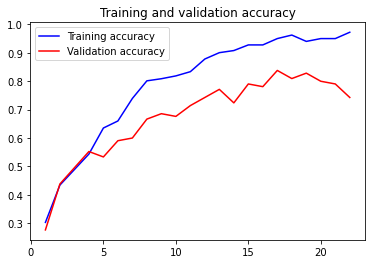

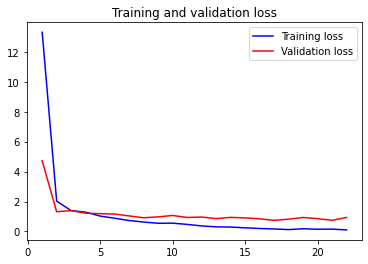

In [64]:
acc = answer_13.history['accuracy']
val_acc = answer_13.history['val_accuracy']
loss = answer_13.history['loss']
val_loss = answer_13.history['val_loss']
 
epochs = range(1,len(acc)+1)
 
plt.figure()
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
#plt.savefig('Accuracy.jpg')
 
plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [65]:
transfer_model_7.evaluate(test_flow)

5/5 [==============================] - 12s 2s/step - loss: 0.8946 - accuracy: 0.7857


[0.8945844173431396, 0.7857142686843872]

In [32]:
y_pred_TL_7 = transfer_model_7.predict(test_flow)
y_pred_TL_7 = np.argmax(y_pred_TL_7, axis=1)

In [33]:
accuracy_TL_7 = accuracy_score(test_flow.classes, y_pred_TL_7)
print("Accuracy in test set for transfer learning InceptionResNetV2 augmented model: %0.1f%% " % (accuracy_TL_7 * 100))

Accuracy in test set for transfer learning InceptionResNetV2 augmented model: 78.6% 


### "TL_trainable_layers" had arasied shape error for InceptionResNetV2 module so learning was ended with untrainable layers

## Best result achieved with model: 

### Conclusions and comparision table

In [7]:
models_dict = dict([
    ('model_std_1.h5', 'Standard Model without Augmentation'),
    ('model_std_2.h5', 'Standard Deeper Model without Augmentation'),
    ('model_aug_1.h5', 'Standard Model with Augmentation'),
    ('model_aug_2.h5', 'Standard Deeper Model with Augmentation'),
    ('model_aug_4.h5', 'Standard Deeper Model with Augmentation and increasing Learning Rate'),
    ('transfer_model.h5', 'VGG19 Tranfer Model'),
    ('transfer_model_2.h5', 'VGG19 Tranfer Model with 2 trainable layers'),
    ('transfer_model_3.h5', 'Xception Tranfer Model'),
    ('transfer_model_5.h5', 'VGG16 Tranfer Model'),
    ('transfer_model_6.h5', 'VGG16 Tranfer Model with 2 trainable layers'),
    ('transfer_model_7.h5', 'InceptionResNetV2 Tranfer Model')
    ])

models_dict

{'model_std_1.h5': 'Standard Model without Augmentation',
 'model_std_2.h5': 'Standard Deeper Model without Augmentation',
 'model_aug_1.h5': 'Standard Model with Augmentation',
 'model_aug_2.h5': 'Standard Deeper Model with Augmentation',
 'model_aug_4.h5': 'Standard Deeper Model with Augmentation and increasing Learning Rate',
 'transfer_model.h5': 'VGG19 Tranfer Model',
 'transfer_model_2.h5': 'VGG19 Tranfer Model with 2 trainable layers',
 'transfer_model_3.h5': 'Xception Tranfer Model',
 'transfer_model_5.h5': 'VGG16 Tranfer Model',
 'transfer_model_6.h5': 'VGG16 Tranfer Model with 2 trainable layers',
 'transfer_model_7.h5': 'InceptionResNetV2 Tranfer Model'}

In [14]:
models_list = []
for key, value in models_dict.items():
    loaded_model = load_model(key)
    preds = loaded_model.predict(test_flow)
    preds = np.argmax(preds, axis=1)
    acc_score = accuracy_score(test_flow.classes, preds)
    models_list.append([value, str(round(acc_score*100, 1)) + '%'])

models_res_df = pd.DataFrame(models_list, columns = ['Method', 'Test Accuracy Score'])

In [15]:
models_res_df

,Method,Test Accuracy Score
0,Standard Model without Augmentation,55.0%
1,Standard Deeper Model without Augmentation,62.9%
2,Standard Model with Augmentation,55.0%
3,Standard Deeper Model with Augmentation,63.6%
4,Standard Deeper Model with Augmentation and in...,60.0%
5,VGG19 Tranfer Model,76.4%
6,VGG19 Tranfer Model with 2 trainable layers,74.3%
7,Xception Tranfer Model,74.3%
8,VGG16 Tranfer Model,77.9%
9,VGG16 Tranfer Model with 2 trainable layers,74.3%


## Best prediction model: InceptionResNetV2

### Finally let's check predictions on random images from test data

In [17]:
transfer_model_7 = load_model('transfer_model_7.h5')

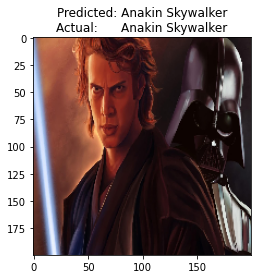

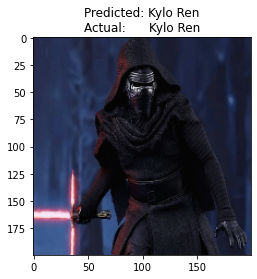

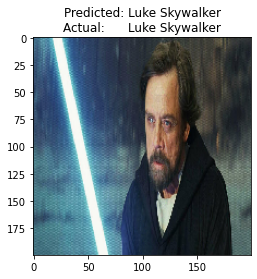

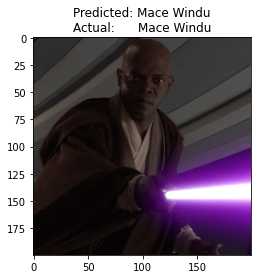

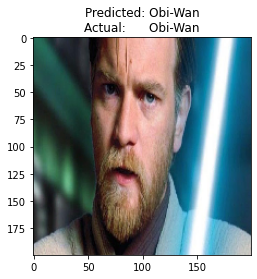

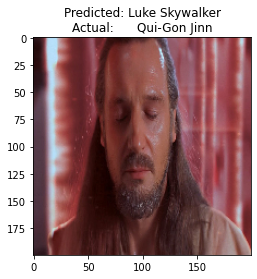

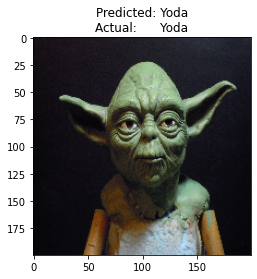

In [18]:
for folder in os.listdir(test_path):
    sub_path=test_path + "\\" + folder
    for i in range(1):
        img_rand = random.choice(os.listdir(sub_path))
        img_file = sub_path + "\\" + img_rand
        image = load_img(img_file,target_size=target_size[0:2])
        img = cv2.imread(img_file, cv2.COLOR_BGR2RGB)
        img = img/255 
        img = cv2.resize(img, (200, 200)) 
        img = np.expand_dims(img, axis=0)
        pred = transfer_model_7.predict(img)
        index = np.argmax(pred)
        pred_emotion = category_names[index]
        real_emotion = folder
        plt.figure()
        plt.title('Predicted: ' + pred_emotion + '\n' + 'Actual:      ' + real_emotion)
        plt.imshow(image)